## Jacobi Method Performance Analysis

### Matrix size: 1000x1000

Threads: 1, Time: 18.463000 seconds
Threads: 2, Time: 10.522000 seconds
Threads: 4, Time: 7.376000 seconds
Threads: 8, Time: 5.974000 seconds
Threads: 16, Time: 6.161000 seconds


,Threads,Time,Speedup,Efficiency
0,1,18.463,1.000000,1.000000
1,2,10.522,1.754704,0.877352
2,4,7.376,2.503118,0.625780
3,8,5.974,3.090559,0.386320
4,16,6.161,2.996754,0.187297


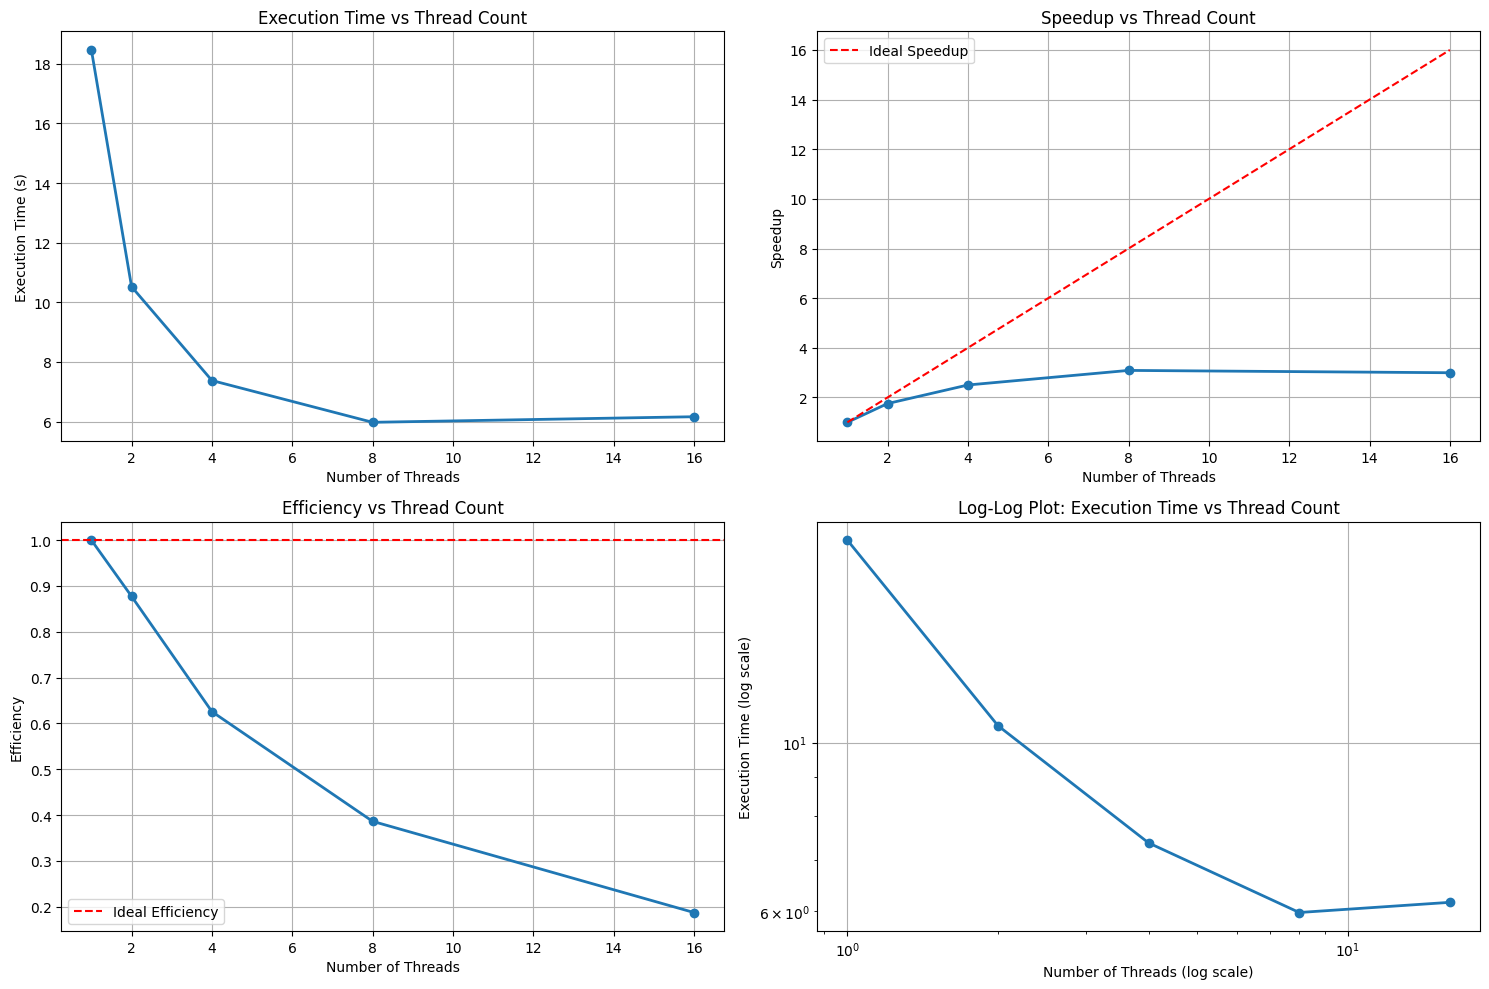

In [ ]:
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown

jacobi_code = """
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <float.h>
#include <math.h>
#include <sys/time.h>
#include <omp.h>

// Default matrix size
#ifndef VAL_N
#define VAL_N 5000
#endif
#ifndef VAL_D
#define VAL_D 80
#endif

// Random initialization of an array 
void random_number(double* array, int size) {
    for (int i = 0; i < size; i++) {
        array[i] = (double)rand() / (double)(RAND_MAX - 1);
    }
}

int main() {
    int n = VAL_N, diag = VAL_D;
    int i, j, iteration = 0;
    double norme;
    
    // Correct 2D matrix allocation
    double *a = (double*)malloc(n * n * sizeof(double));
    double *x = (double*)malloc(n * sizeof(double));
    double *x_courant = (double*)malloc(n * sizeof(double));
    double *b = (double*)malloc(n * sizeof(double));
    
    if (!a || !x || !x_courant || !b) {
        fprintf(stderr, "Memory allocation failed!\\n");
        exit(EXIT_FAILURE);
    }
    
    // Time measurement variables
    struct timeval t_elapsed_0, t_elapsed_1;
    double t_elapsed;
    double t_cpu_0, t_cpu_1, t_cpu;
    
    // Matrix and RHS initialization
    srand(421); // For reproducibility
    random_number(a, n * n);
    random_number(b, n);
    
    // Strengthening the diagonal
    #pragma omp parallel for
    for (i = 0; i < n; i++) {
        a[i * n + i] += diag; // Corrected indexing
    }
    
    // Initial solution
    #pragma omp parallel for
    for (i = 0; i < n; i++) {
        x[i] = 1.0;
    }
    
    // Start timing
    t_cpu_0 = omp_get_wtime();
    gettimeofday(&t_elapsed_0, NULL);
    
    // Jacobi Iteration
    while (1) {
        iteration++;
        
        #pragma omp parallel for private(j)
        for (i = 0; i < n; i++) {
            x_courant[i] = 0;
            for (j = 0; j < i; j++) {
                x_courant[i] += a[i * n + j] * x[j]; // Using row-major indexing
            }
            for (j = i + 1; j < n; j++) {
                x_courant[i] += a[i * n + j] * x[j]; // Using row-major indexing
            }
            x_courant[i] = (b[i] - x_courant[i]) / a[i * n + i];
        }
        
        // Convergence test
        double absmax = 0;
        #pragma omp parallel
        {
            double local_absmax = 0;
            
            #pragma omp for
            for (i = 0; i < n; i++) {
                double curr = fabs(x[i] - x_courant[i]);
                if (curr > local_absmax)
                    local_absmax = curr;
            }
            
            #pragma omp critical
            {
                if (local_absmax > absmax)
                    absmax = local_absmax;
            }
        }
        
        norme = absmax / n;
        
        if ((norme <= DBL_EPSILON) || (iteration >= n)) 
            break;
        
        // Copy x_courant to x
        #pragma omp parallel for
        for (i = 0; i < n; i++) {
            x[i] = x_courant[i];
        }
    }
    
    // End timing
    gettimeofday(&t_elapsed_1, NULL);
    t_elapsed = (t_elapsed_1.tv_sec - t_elapsed_0.tv_sec) +
                (t_elapsed_1.tv_usec - t_elapsed_0.tv_usec) / 1e6;
    t_cpu_1 = omp_get_wtime();
    t_cpu = t_cpu_1 - t_cpu_0;
    
    // Print only the CPU time for our analysis
    printf("%f", t_cpu);
    
    // Free allocated memory
    free(a);
    free(x);
    free(x_courant);
    free(b);
    
    return EXIT_SUCCESS;
}
"""

with open("jacobi.c", "w") as f:
    f.write(jacobi_code)

subprocess.run(["gcc", "-fopenmp", "-o", "jacobi", "jacobi.c"])
display(Markdown("## Jacobi Method Performance Analysis"))
display(Markdown("### Matrix size: " + str(1000) + "x" + str(1000)))

thread_counts = [1, 2, 4, 8, 16]
results = []

for threads in thread_counts:
    env = os.environ.copy()
    env["OMP_NUM_THREADS"] = str(threads)
    output = subprocess.check_output(["jacobi"], env=env)
    execution_time = float(output.decode().strip())
    results.append(execution_time)
    print(f"Threads: {threads}, Time: {execution_time:.6f} seconds")

df = pd.DataFrame({
    'Threads': thread_counts,
    'Time': results,
    'Speedup': [results[0]/t for t in results],
    'Efficiency': [results[0]/t/n for n, t in zip(thread_counts, results)]
})

display(df)
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(df['Threads'], df['Time'], 'o-', linewidth=2)
plt.xlabel('Number of Threads')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs Thread Count')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(df['Threads'], df['Speedup'], 'o-', linewidth=2)
plt.plot(df['Threads'], df['Threads'], 'r--', label='Ideal Speedup')
plt.xlabel('Number of Threads')
plt.ylabel('Speedup')
plt.title('Speedup vs Thread Count')
plt.legend()
plt.grid(True)

plt.axhline(y=1, color='r', linestyle='--', label='Ideal Efficiency')
plt.xlabel('Number of Threads')
plt.ylabel('Efficiency')
plt.title('Efficiency vs Thread Count')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.loglog(df['Threads'], df['Time'], 'o-', linewidth=2)
plt.xlabel('Number of Threads (log scale)')
plt.ylabel('Execution Time (log scale)')
plt.title('Log-Log Plot: Execution Time vs Thread Count')
plt.grid(True)

plt.tight_layout()
plt.show()

os.remove("jacobi.c")